In [3]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Convex, ECOS  # Convex modeling and solver
using Distributions, Random  # Seeds and sampling
using LightGraphs  # Generating nice random graphs
using Plots, Colors  # For plottig

using Revise
using CarbonNetworks

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1317
┌ Info: Precompiling CarbonNetworks [d5dced0a-5569-40db-8865-1dbf132a76f2]
└ @ Base loading.jl:1317


# Load data

## Load network

In [6]:
DATAPATH = "/Users/degleris/Data/carbon_networks/"
A, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH)
n = length(gmax)
m = length(pmax)

@show n, m

# We now consider hydro to be fixed
inds = findall(v -> v[3] in ["WAT"], nodes)
gmax[inds] .*= 0.0;  

(n, m) = (684, 775)


## Load case

In [11]:
case = DataFrame(CSV.File(CarbonNetworks.get_data_path(DATAPATH, "case_4.csv")))
rename!(case, "Column1" => "ba")
case = coalesce.(case, 0.0)

bas = case[:, "ba"]
demands = case[:, "net_demand"] - case[:, "WAT"]

d = zeros(n)
for (dem, ba) in zip(demands, bas)
    ind_d = findfirst(x -> x[2:3] == (ba, "DEMAND"), nodes)
    d[ind_d] = dem
end

@show sum(gmax)
@show sum(d);

sum(gmax) = 800797.7917451549
sum(d) = 264354.7671466503


# Let's solve the carbon minimization problem

In [12]:
primary_nodes = [ind for (ind, iso, res) in nodes if res == "DEMAND"]
primary_edges = [ind for (ind, e) in enumerate(edges(G)) 
        if e.src in primary_nodes && e.dst in primary_nodes];

In [160]:
# Make 'infinite' constraint large but not tight
p̃ = copy(pmax)
p̃[p̃ .== Inf] .= 1.5 * maximum(gmax)


# Scaling is important
scale = mean(d[d .!= 0])

d̃ = d / scale
g̃ = gmax / scale
p̃ /= scale


params = (f, d̃, p̅, g̃, A)

carbon_min = PowerManagementProblem(params...)
solve!(carbon_min, () -> ECOS.Optimizer(verbose=false))

g = evaluate(carbon_min.g)
p = evaluate(carbon_min.p)

#println("Percent of power exchanged: $(sum(abs.(p[primary_edges])) / sum(d))")

@show maximum(abs.(p) - p̅)
@show maximum(g - gmax)
@show maximum(-g)
@show norm(A*p - g + d̃)

maximum(abs.(p) - p̅) = -16.556233254164837
maximum(g - gmax) = 1.511931361127648e-7
maximum(-g) = 1.9248457184429102e-9
norm((A * p - g) + d̃) = 7.908427206963997e-6


7.908427206963997e-6

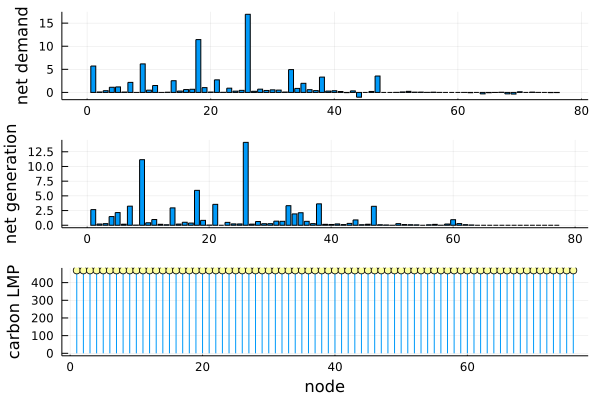

In [199]:
ν = get_lmps(carbon_min)[primary_nodes]
d_primary = d̃[primary_nodes]

push!(primary_nodes, lastindex(g))
g_primary = [sum(g[[tup[2] == nodes[i][2] for tup in nodes]]) for i in primary_nodes]
gmax_primary = [sum(g̃[[v[2] == nodes[i][2] for v in nodes]]) for i in primary_nodes]
pop!(primary_nodes)

gradient = cgrad(:inferno)
lmp_colors = [get(gradient, νi/maximum(ν)) for νi in ν]

plt1 = bar(d_primary, label=nothing, ylabel="net demand")
plt2 = bar(g_primary, label=nothing, ylabel="net generation")
#bar!(plt2, g_primary, label=nothing)

plt3 = sticks(ν, label=nothing, ylabel="carbon LMP", xlabel="node")
scatter!(plt3, ν, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))

## Aggregrate generation by resource

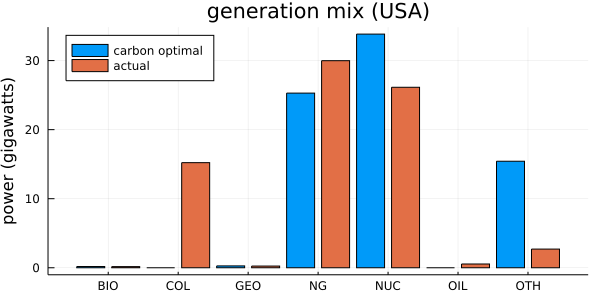

In [202]:
resources = unique([v[3] for v in nodes])
resources = resources[2:end-1]  # Remove demand and hydro

ba_id(ba) = findfirst(==(ba), bas)
res_id(res) = findfirst(==(res), resources)

gen_matrix = zeros(length(bas), length(resources))
gen_max_matrix = zeros(length(bas), length(resources))
for (id, ba, res) in nodes
    (res == "DEMAND" || res == "WAT") && continue

    #@show ba_id(ba), res_id(res)
    
    gen_matrix[ba_id(ba), res_id(res)] = g[id]
    gen_max_matrix[ba_id(ba), res_id(res)] = g̃[id]
end

max_dispatch = sum(gen_max_matrix, dims=1)[1, :]
carb_min_dispatch = sum(gen_matrix, dims=1)[1, :]
actual_dispatch = sum(Matrix(case[:, resources]), dims=1)[1, :] / scale

theme(:default)
x = 1:length(carb_min_dispatch)
plt = plot(size=(600, 300))
bar!(x .- 0.25, carb_min_dispatch, bar_width=0.4, label="carbon optimal")
bar!(x .+ 0.25, actual_dispatch, bar_width=0.4, label="actual")
plot!(xticks=(1:length(carb_min_dispatch), resources), ylabel="power (gigawatts)")
plot!(legend=:topleft, title="generation mix (USA)")
savefig(plt, "./gen_mix.png")
display(plt)

# Incorporate prices